# Evaluación de los resultados
[Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
Datos de una campaña de marketing bancario. Predice si un cliente suscribirá un depósito a plazo fijo.
En este notebook se muestran técnicas para la evaluación de los resultados de una predicción con un algoritmo de Machine Learning

## Conjunto de datos

### Descripción

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:

1. bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2. bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3. bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4. bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
   The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Ficheros de datos

- <span style="color:green">bank.zip</span>
- <span style="color:green">bank-additional.zip</span>

### Descarga de los ficheros de datos

[Enlace](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip)

### Adicional Variable Información

Input variables:

#### bank client data:

1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no")

#### related with the last contact of the current campaign:

9. contact: contact communication type (categorical: "unknown","telephone","cellular")
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric)

#### other attributes:

13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
17. y has the client subscribed a term deposit? (binary: "yes","no")


## Imports

In [1]:
try:
    import pandas as pd
    import sklearn
except ImportError:
    %pip install -q pandas scikit-learn matplotlib scipy imbalanced-learn

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,
    f1_score, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

from imblearn.over_sampling import SMOTE

print("Bibliotecas cargadas correctamente.")


Bibliotecas cargadas correctamente.


## Funciones Genéricas

In [2]:
# Función para cargar el dataset
def load_dataset(data_path, delimiter=';'):
    df = pd.read_csv(data_path, delimiter=delimiter)
    pd.set_option('display.max_columns', None)
    return df

# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return train_set, val_set, test_set

In [3]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('rbst_scaler', RobustScaler())
])

In [4]:
# Transormador para codificar únicamente las columnas categoricas y devolver un DataFrame
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._columns = None

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object']).copy()
        self._oh.fit(X_cat)
        self._columns = self._oh.get_feature_names_out(X_cat.columns)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object']).copy()
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, columns=self._columns, index=X_copy.index)
        X_copy.drop(columns=X_cat.columns, inplace=True)
        return X_copy.join(X_cat_oh)

In [5]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados

class DataFramePreparer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self._full_pipeline = None
        self._columns = None

    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']).columns)
        cat_attribs = list(X.select_dtypes(include=['object']).columns)

        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])

        self._full_pipeline.fit(X, y)
        self._columns = pd.get_dummies(X).columns

        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)

        return pd.DataFrame(X_prep, columns=self._columns, index=X_copy.index)


## Lectura del conjunto de datos

In [6]:
df_orig = load_dataset("./datasets/bank+marketing/bank/bank-full.csv")
df = df_orig.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


## División del conjunto de datos

In [8]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df, stratify='y')

In [9]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 27126
Longitud del Validation Set: 9042
Longitud del Test Set: 9043


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [10]:
# Conjunto de datos general
X_df = df.drop("y", axis=1)
y_df = df["y"].copy()

In [11]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("y", axis=1)
y_train = train_set["y"].copy()

In [12]:
# Conjunto de datos de validación
X_val = val_set.drop("y", axis=1)
y_val = val_set["y"].copy()

In [13]:
# Conjunto de datos de pruebas
X_test = test_set.drop("y", axis=1)
y_test = test_set["y"].copy()

## Preparación del conjunto de datos

In [14]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [15]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

DataFramePreparer()

In [16]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [17]:
X_train.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
217,53,unemployed,married,unknown,no,13,no,no,unknown,5,may,410,3,-1,0,unknown
34160,54,technician,married,secondary,no,0,no,no,telephone,30,apr,766,3,84,3,success
34607,30,self-employed,single,secondary,no,280,no,no,telephone,5,may,92,3,-1,0,unknown
447,50,self-employed,married,unknown,no,-84,yes,no,unknown,6,may,101,1,-1,0,unknown
23636,60,self-employed,married,secondary,no,1690,no,no,cellular,28,aug,64,11,-1,0,unknown


In [18]:
X_train_prep.head(5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
217,0.933333,-0.320796,-0.846154,1.064815,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34160,1.000000,-0.330383,1.076923,2.712963,0.5,85.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34607,-0.600000,-0.123894,-0.846154,-0.407407,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
447,0.733333,-0.392330,-0.769231,-0.365741,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23636,1.400000,0.915929,0.923077,-0.537037,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# Transformamos el subconjunto de datos de validación
X_val_prep = data_preparer.transform(X_val)
X_test_prep = data_preparer.transform(X_test)

## Entrenamiento de un algoritmo de Regresión Logística

La instanciación de un algoritmo de Machine Learning utilizando Sklearn se realiza utilizando los métodos expuestos por la API de sklearn tal y como se ha presentado en cuadernos anteriores. En este caso vamos a pedirle al modelo que se entrene durante más tiempo, concretamente 1.000 iteraciones.

In [20]:
# Entrenamos un algoritmo basado en regresión logística
clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_prep, y_train)


LogisticRegression(max_iter=1000, solver='newton-cg')

## Predicción de nuevos ejemplos

### Evalúamos nuestro modelo utilizando los tres conjuntos de datos mediante las métricas numéricas.

In [21]:
# Función para evaluar nuestro conjunto de datos
def evaluar_modelo(y_true, y_pred, nombre):
    print(f"\n🔹 Evaluación en {nombre}:")
    print(f"Precisión: {precision_score(y_true, y_pred, pos_label='yes')}")
    print(f"Recall: {recall_score(y_true, y_pred, pos_label='yes')}")
    print(f"F1-score: {f1_score(y_true, y_pred, pos_label='yes')}")

In [22]:
evaluar_modelo(y_train, clf.predict(X_train_prep), "Train")



🔹 Evaluación en Train:
Precisión: 0.6471652593486128
Recall: 0.3381657737157264
F1-score: 0.44421444835437796


In [23]:
evaluar_modelo(y_val, clf.predict(X_val_prep), "Validation")


🔹 Evaluación en Validation:
Precisión: 0.6514886164623468
Recall: 0.3516068052930057
F1-score: 0.4567219152854512


In [24]:
evaluar_modelo(y_test, clf.predict(X_test_prep), "Test")



🔹 Evaluación en Test:
Precisión: 0.6739526411657559
Recall: 0.3497164461247637
F1-score: 0.46048537647790916


#### 1 Precision
El modelo es preciso , pero solo en la clase "yes".

#### 2 Recall
El recall es bajo, lo cual es un problema.

#### 3 F1-score
El F1-score es bajo debido al bajo recall.

#### ¿Qué significa esto?
- El modelo es mejor descartando clientes que no se suscribirán ("no") que detectando correctamente los que sí lo harán ("yes")
-  El desbalance de datos afecta la predicción de "yes": el modelo prefiere predecir "no" porque es la clase mayoritaria.
-  Para mejorar, deberíamos aumentar el recall, aunque eso pueda reducir un poco la precisión.

### Evaluación Gráfica

In [25]:
def evaluar_modelo_graficamente(clf, X_prep, y_true, nombre):
    """
    Genera gráficos de evaluación para un modelo de clasificación.
    """
    print(f"\n🔹 Gráficos de Evaluación para {nombre}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Matriz de Confusión
    ConfusionMatrixDisplay.from_estimator(clf, X_prep, y_true, values_format='d', ax=axes[0])
    axes[0].set_title(f'Matriz de Confusión ({nombre})')

    # Curva ROC
    RocCurveDisplay.from_estimator(clf, X_prep, y_true, ax=axes[1])
    axes[1].set_title(f'Curva ROC ({nombre})')

    # Curva Precisión-Recall
    PrecisionRecallDisplay.from_estimator(clf, X_prep, y_true, ax=axes[2])
    axes[2].set_title(f'Curva Precisión-Recall ({nombre})')

    plt.show()



🔹 Gráficos de Evaluación para Train


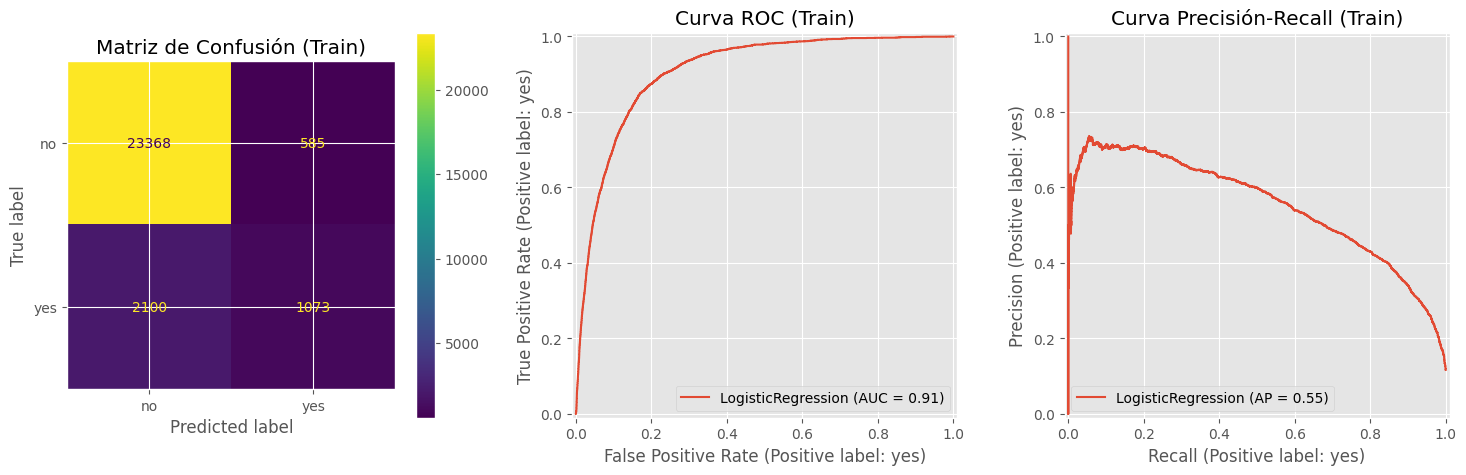

In [26]:
evaluar_modelo_graficamente(clf, X_train_prep, y_train, "Train")


🔹 Gráficos de Evaluación para Validation


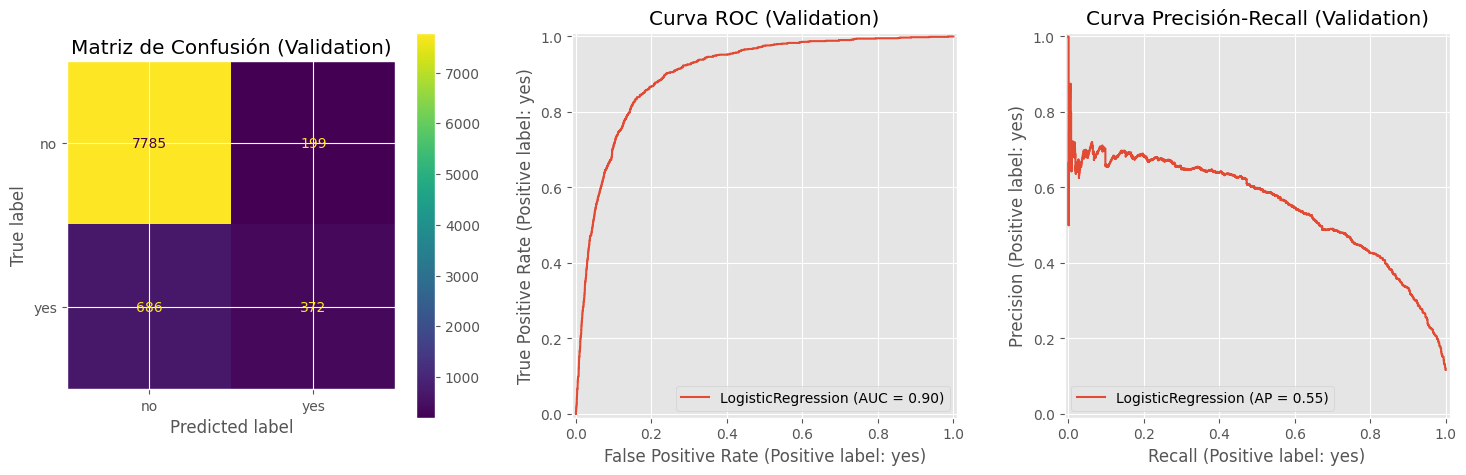

In [27]:
evaluar_modelo_graficamente(clf, X_val_prep, y_val, "Validation")


🔹 Gráficos de Evaluación para Test


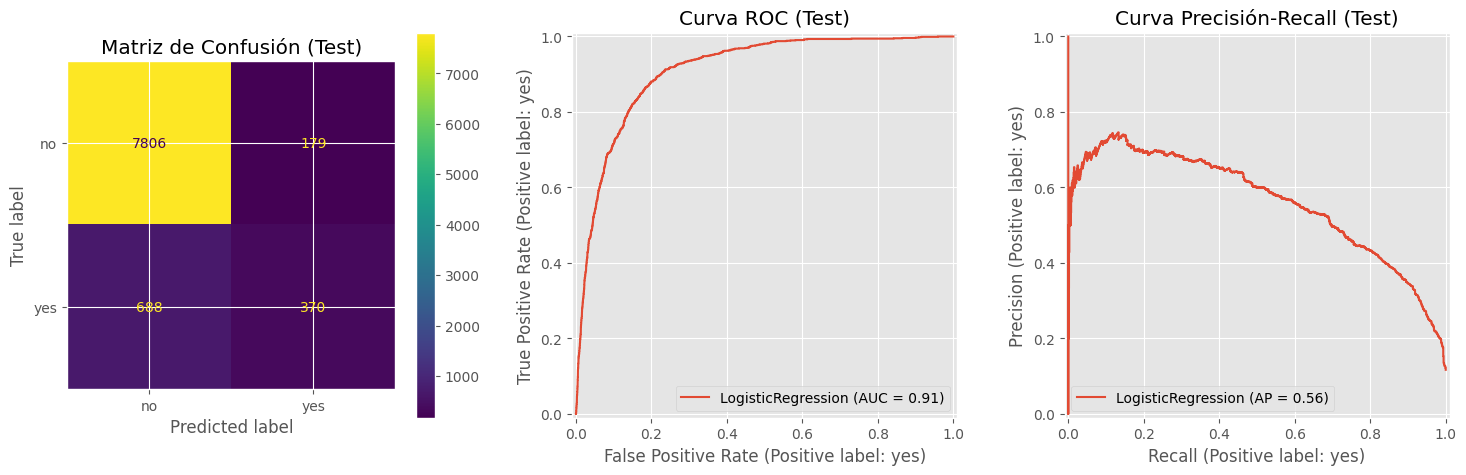

In [28]:
evaluar_modelo_graficamente(clf, X_test_prep, y_test, "Test")

## Mejoras del modelo

Para mejorar el recall y hacer que el modelo detecte mejor "yes", podemos probar las siguientes estrategias:

In [29]:
# Entrenamos el modelo con random forest
clf_base = RandomForestClassifier(random_state=42)
clf_base.fit(X_train_prep, y_train)

# Evaluamos en el conjunto de validación
y_pred_base = clf_base.predict(X_val_prep)
print("\n🔹 Evaluación del Modelo Base:")
print(classification_report(y_val, y_pred_base))



🔹 Evaluación del Modelo Base:
              precision    recall  f1-score   support

          no       0.92      0.98      0.95      7984
         yes       0.67      0.39      0.49      1058

    accuracy                           0.91      9042
   macro avg       0.80      0.68      0.72      9042
weighted avg       0.89      0.91      0.90      9042



### Rebalanceo de clases con SMOTE
El desbalance de clases está afectando al rendimiento de nuestro modelo, ya que hay más "no" que "yes"

In [30]:

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_prep, y_train)

# Entrenar el modelo con los datos balanceados
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_resampled, y_train_resampled)

# Evaluar el modelo con SMOTE
y_pred_smote = clf_smote.predict(X_val_prep)
print("\n🔹 Evaluación del Modelo con SMOTE:")
print(classification_report(y_val, y_pred_smote))



🔹 Evaluación del Modelo con SMOTE:
              precision    recall  f1-score   support

          no       0.94      0.95      0.95      7984
         yes       0.59      0.52      0.55      1058

    accuracy                           0.90      9042
   macro avg       0.77      0.74      0.75      9042
weighted avg       0.90      0.90      0.90      9042



### Entrenar con class_weight="balanced"
Otra estrategia es decirle al modelo que dé más importancia a la clase "yes" sin cambiar los datos.

In [31]:
# Entrenar un modelo con class_weight="balanced"
clf_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
clf_balanced.fit(X_train_prep, y_train)

# Evaluar el modelo con class_weight="balanced"
y_pred_balanced = clf_balanced.predict(X_val_prep)
print("\n🔹 Evaluación del Modelo con class_weight='balanced':")
print(classification_report(y_val, y_pred_balanced))


🔹 Evaluación del Modelo con class_weight='balanced':
              precision    recall  f1-score   support

          no       0.91      0.98      0.95      7984
         yes       0.68      0.31      0.43      1058

    accuracy                           0.90      9042
   macro avg       0.80      0.65      0.69      9042
weighted avg       0.89      0.90      0.89      9042

